# Problem Statement :  Build a multiclass classification model using a custom convolutional neural network in TensorFlow.

Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

1. Actinic keratosis
2. Basal cell carcinoma
3. Dermatofibroma
4. Melanoma
5. Nevus
6. Pigmented benign keratosis
7. Seborrheic keratosis
8. Squamous cell carcinoma
9. Vascular lesion



# Notebook Structure

1. Import necessary libraries
2. Import the Dataset
3. Segregating the Dataset into Training and validation set
4. Data Visualization
5. Create the baseline model - Model 1
6. Data Augmentation strategy
7. Create Model 2 - adding Dropout Layer as part of the architecture
8. Class Inbalance Analysis
9. Rectify the class imbalance
10. Train the model on the data created using Augmentor - Model 3

# 1. Import necessary libraries

In [44]:
! pip install tensorflow

In [45]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# 2. Import the Dataset

In [46]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [49]:
# Defining the path for train and test images
## Paths of train and test dataset on Google drive

data_dir_train = pathlib.Path("/content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [50]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2249
118


In [51]:
batch_size = 32
img_height = 180
img_width = 180

# 3. Segregating the Dataset into Training and validation set

In [52]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2249 files belonging to 9 classes.
Using 1800 files for training.


In [53]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2249 files belonging to 9 classes.
Using 449 files for validation.


In [54]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# 4. Data Visualization

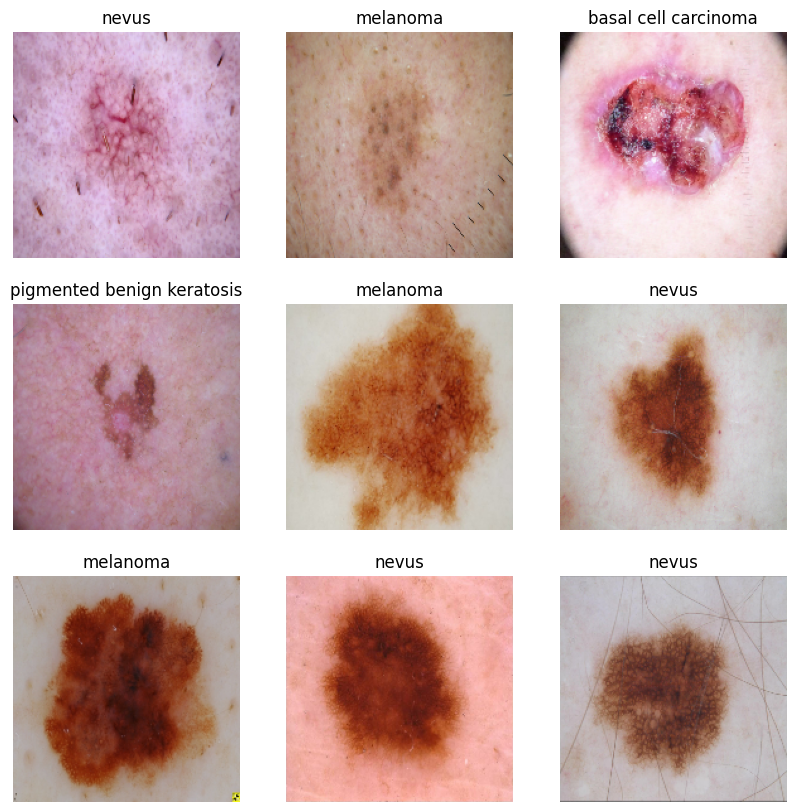

In [55]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [56]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 5. Create the baseline model - Model 1

In [57]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Rescaling
import warnings
warnings.filterwarnings('ignore')

### a. CNN neural network architecture design

In [58]:


# Number of target labels are 9
target_labels = 9

model = Sequential([
  Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

### b. Compile the model with adam optimizer

In [59]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### c. Summarize the model

In [60]:
# View the summary of all layers
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### d. fit the model with epochs = 20

In [61]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.2878 - loss: 1.9123 - val_accuracy: 0.3608 - val_loss: 1.6625
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.4514 - loss: 1.5762 - val_accuracy: 0.4165 - val_loss: 1.5932
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.4866 - loss: 1.4770 - val_accuracy: 0.5033 - val_loss: 1.4544
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5495 - loss: 1.3118 - val_accuracy: 0.4811 - val_loss: 1.4795
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.5542 - loss: 1.2705 - val_accuracy: 0.5033 - val_loss: 1.3970
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.5783 - loss: 1.1972 - val_accuracy: 0.5212 - val_loss: 1.3504
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.6315 - loss: 1.0448 - val_accuracy: 0.5145 - val_loss: 1.4770
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.6537 - loss: 0.9457 - val_accuracy: 0.5256 - val_loss

### e. Visualizing the training result

The Training accuracy is [0.33500000834465027, 0.4566666781902313, 0.4927777647972107, 0.5327777862548828, 0.5666666626930237, 0.57833331823349, 0.6366666555404663, 0.647777795791626, 0.6833333373069763, 0.7105555534362793, 0.7472222447395325, 0.7883333563804626, 0.7894444465637207, 0.777222216129303, 0.8188889026641846, 0.8572221994400024, 0.875, 0.8855555653572083, 0.8861111402511597, 0.8966666460037231]
The Validation accuracy is [0.3608017861843109, 0.416481077671051, 0.5033407807350159, 0.48106902837753296, 0.5033407807350159, 0.5211581587791443, 0.5144765973091125, 0.525612473487854, 0.5523385405540466, 0.5456570386886597, 0.5456570386886597, 0.5478841662406921, 0.4966592490673065, 0.4944320619106293, 0.5144765973091125, 0.5100222826004028, 0.5345211625099182, 0.5011135935783386, 0.5278396606445312, 0.5122494697570801]
The Training loss is [1.8093149662017822, 1.5800868272781372, 1.4500763416290283, 1.3462835550308228, 1.2392303943634033, 1.1990585327148438, 1.0437579154968262, 0

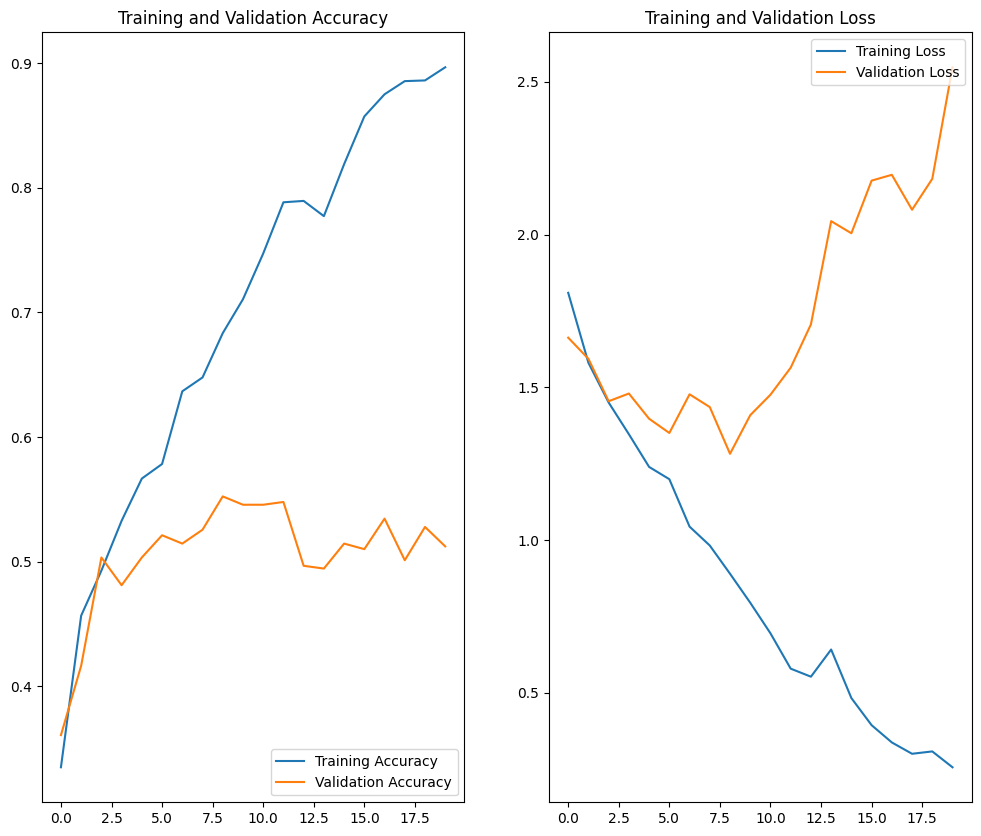

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print("The Training accuracy is " + str(acc))
print("The Validation accuracy is " + str(val_acc))

loss = history.history['loss']
val_loss = history.history['val_loss']
print("The Training loss is " + str(loss))
print("The Validation loss is " + str(val_loss))

epochs_range = range(epochs)

plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations :

1. The model's training accuracy shows a steady increase of upto 89%, while validation accuracy remains consistently around 51%.

2. high training accuracy coupled with poor performance on validation data indicates a lack of generalizability and overfitting

These observations confirm the presence of overfitting. To address this issue, augmentation techniques will be employed. Given the limited training data available, new samples will be generated by making slight modifications to existing data (such as horizontal/vertical image flipping, minor image rotations, etc.) that will be used to retrain the model

# 6. Data Augmentation strategy

### Augmentation Data Generation

1. RandomFlip : his layer randomly flips the input images horizontally with a probability of 50%.

2. RandomRotation : This layer randomly rotates the input images by a random angle within a range of -10% to 10% of the original image dimensions.

3. RandomZoom : This layer randomly zooms in or out on the input images by a random factor within a range of -10% to 10% of the original image dimensions.

In [63]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.


augmentation_data = keras.Sequential([
                                      layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.1),
])

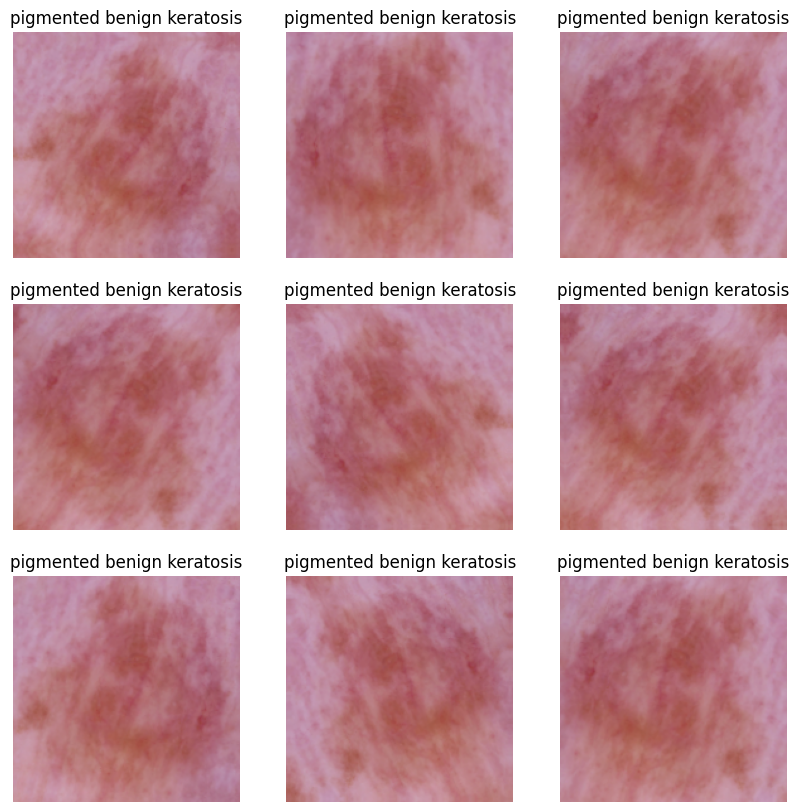

In [64]:
# Visualize how your augmentation strategy works for one instance of training image.


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

# 7. Create  Model 2 - adding Dropout Layer as part of the architecture

a. CNN neural network architecture design with Dropout layer and augmentation data

In [65]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

b. Compile the model with adam optimizer

In [66]:


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

c. Summarize the model

In [67]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

d. fit the model with epochs = 20

In [68]:
%%time
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.2235 - loss: 2.0999 - val_accuracy: 0.3007 - val_loss: 1.8289
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.3620 - loss: 1.7752 - val_accuracy: 0.3318 - val_loss: 1.8025
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.3980 - loss: 1.6739 - val_accuracy: 0.4477 - val_loss: 1.5491
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.4767 - loss: 1.4967 - val_accuracy: 0.4811 - val_loss: 1.4747
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.4965 - loss: 1.4686 - val_accuracy: 0.4788 - val_loss: 1.4715
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.5259 - loss: 1.3643 - val_accuracy: 0.5122 - val_loss: 1.3630
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5338 - loss: 1.3291 - val_accuracy: 0.5234 - val_loss: 1.3429
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5457 - loss: 1.3090 - val_accuracy: 0.5212 - val_los

e. Visualizing the training result

The Training accuracy is [0.2705555558204651, 0.36500000953674316, 0.4166666567325592, 0.4716666638851166, 0.49444442987442017, 0.5299999713897705, 0.5350000262260437, 0.5450000166893005, 0.5433333516120911, 0.5594444274902344, 0.5627777576446533, 0.5649999976158142, 0.5822222232818604, 0.5799999833106995, 0.6155555844306946, 0.5899999737739563, 0.5877777934074402, 0.6244444251060486, 0.6188889145851135, 0.6272222399711609]
The Validation accuracy is [0.3006681501865387, 0.3318485617637634, 0.44766145944595337, 0.48106902837753296, 0.4788418710231781, 0.5122494697570801, 0.5233852863311768, 0.5211581587791443, 0.518930971622467, 0.5144765973091125, 0.4832962155342102, 0.525612473487854, 0.4988864064216614, 0.5278396606445312, 0.5434298515319824, 0.5055679082870483, 0.5055679082870483, 0.518930971622467, 0.5434298515319824, 0.5567928552627563]
The Training loss is [1.9794707298278809, 1.7544916868209839, 1.6373740434646606, 1.501038908958435, 1.4770381450653076, 1.3565359115600586, 1.33

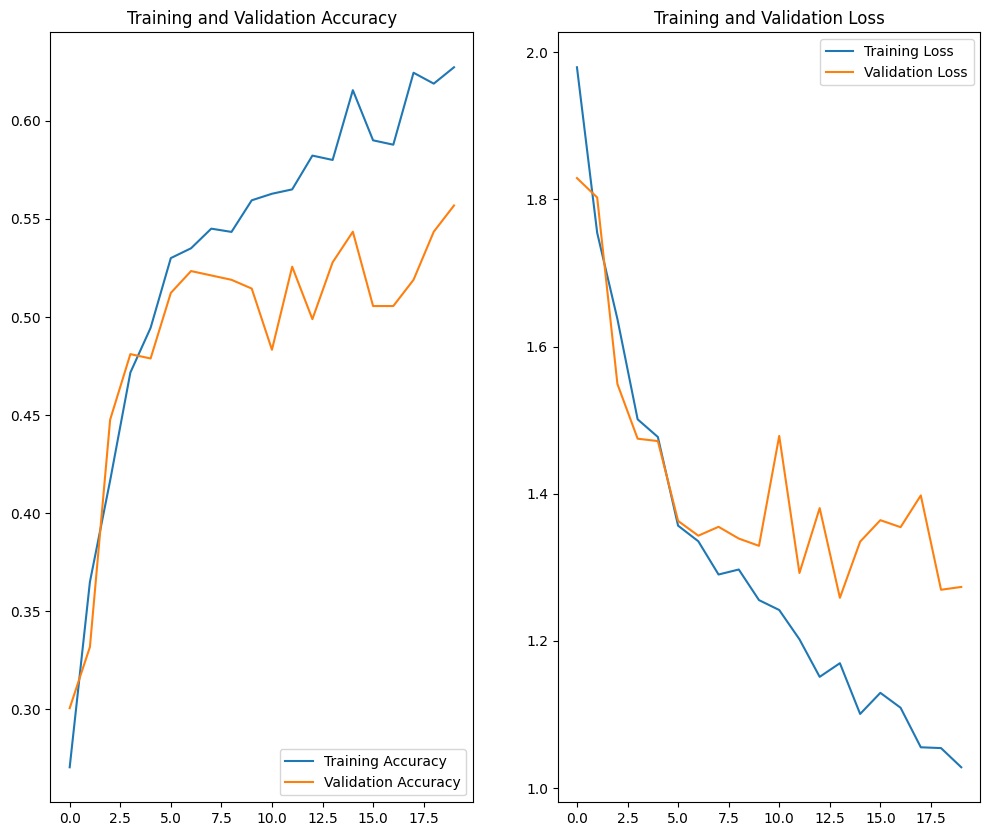

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print("The Training accuracy is " + str(acc))
print("The Validation accuracy is " + str(val_acc))

loss = history.history['loss']
val_loss = history.history['val_loss']
print("The Training loss is " + str(loss))
print("The Validation loss is " + str(val_loss))


epochs_range = range(epochs)

plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations :

The training ( 62% ) and validation accuracy ( 55% ) of the aforementioned model fall within a similar range , which means we have handled overfitting to some extent by using dropout layer

But the training data are showing poor performance, indicating that the model is now exhibiting underfitting.

# 8. Class Inbalance Analysis

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

### a. Find the image path and extract all class labels

In [70]:

from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2249


### b. Extract image path and class label in a dictionary

In [71]:

image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025953.jpg', 'actinic keratosis'), ('/content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0026171.jpg', 'actinic keratosis'), ('/content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025825.jpg', 'actinic keratosis'), ('/content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025803.jpg', 'actinic keratosis'), ('/content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/ISIC_0025780.jpg', 'actinic keratosis')]


### c. View the image path and class label in a df

In [72]:

lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,/content/gdrive/My Drive/Capgemini/CNN_assignm...,actinic keratosis
1,/content/gdrive/My Drive/Capgemini/CNN_assignm...,actinic keratosis
2,/content/gdrive/My Drive/Capgemini/CNN_assignm...,actinic keratosis
3,/content/gdrive/My Drive/Capgemini/CNN_assignm...,actinic keratosis
4,/content/gdrive/My Drive/Capgemini/CNN_assignm...,actinic keratosis


### d. frequency by class levels - numerical representation

In [73]:
lesions_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,380
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,120
dermatofibroma,95
seborrheic keratosis,77


### e. Data visualization of frequency by class labels

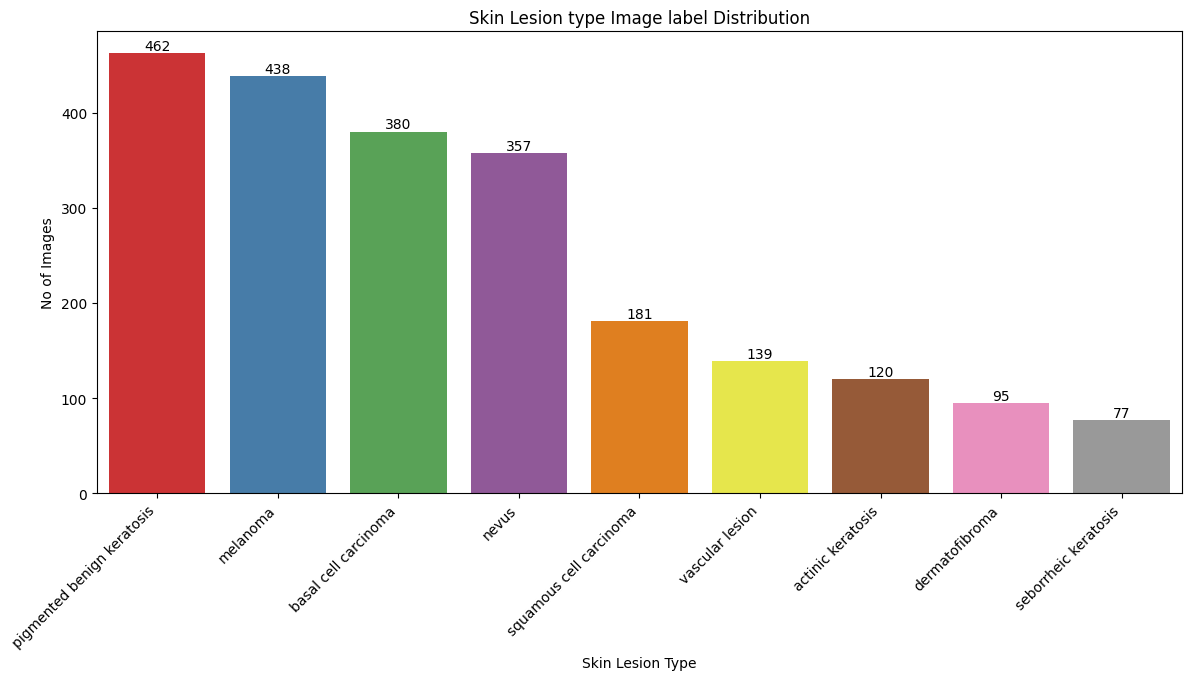

In [74]:
import seaborn as sns
plt.figure(figsize=(14, 6))
sns.barplot(lesions_df['Label'].value_counts() , palette = 'Set1');

# Show bar values on top of the bars
for bar in plt.gca().patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, int(height), ha='center', va='bottom')  # Adjust vertical offset (0.1) as needed

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Skin Lesion type Image label Distribution')
plt.xlabel('Skin Lesion Type')
plt.ylabel('No of Images')
plt.show()

### f. Proportionate distribution of labels by class

In [75]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,20.54
melanoma,19.48
basal cell carcinoma,16.90
nevus,15.87
squamous cell carcinoma,8.05
vascular lesion,6.18
actinic keratosis,5.34
dermatofibroma,4.22
seborrheic keratosis,3.42


### Observation

1. A clear class imbalance is evident within the training data.

2. "Pigmented benign keratosis" and "melanoma" significantly outweigh other classes, representing approximately 21% and 20% of the data, respectively.

3. The class "dermatofibroma" and "seborrheic keratosis" comprises the smallest proportion of samples, accounting for approximately 4% and 3% respectively



# 9. Rectify the class imbalance

In [76]:
!pip install Augmentor

In [77]:
path_to_training_dataset = str(data_dir_train) + '/'

import Augmentor

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 120 image(s) found.
Output directory set to /content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A0F5808B940>: 100%|██████████| 500/500 [00:37<00:00, 13.47 Samples/s]


Initialised with 380 image(s) found.
Output directory set to /content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A0F5A933970>: 100%|██████████| 500/500 [00:28<00:00, 17.43 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A0F5AA67190>: 100%|██████████| 500/500 [00:31<00:00, 16.11 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A0F5A10B250>: 100%|██████████| 500/500 [01:34<00:00,  5.27 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A0F5AA23A30>: 100%|██████████| 500/500 [01:43<00:00,  4.81 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A0F73105D80>: 100%|██████████| 500/500 [00:26<00:00, 18.67 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7A0F58B3DA50>: 100%|██████████| 500/500 [00:53<00:00,  9.32 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7A0F58A37EB0>: 100%|██████████| 500/500 [00:28<00:00, 17.40 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7A0F7511B1F0>: 100%|██████████| 500/500 [00:29<00:00, 16.75 Samples/s]


In [78]:
# Verifying the total count of images after the augmentation

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [79]:
# extracting the augmented image paths in a list

path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026194.jpg_5f5a590a-57cb-4b47-b4ae-8a7de3e5fabb.jpg',
 '/content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033151.jpg_4ad875d3-84ab-4173-b0cc-bd52bd958330.jpg',
 '/content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030825.jpg_26afc7ee-81b4-46ca-bb5f-b6fc0adb3259.jpg',
 '/content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027884.jpg_306d0af9-caa7-4aab-bd0e-361b55207406.jpg',
 '/content/gdrive/My Drive/Capgemini/CNN_assignment/Skin cancer ISIC The

In [80]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [81]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [82]:
df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
augmented_df = pd.concat([lesions_df, df])
augmented_df.shape

(6749, 2)

In [83]:
# View the augmented image paths and labels in a new df

augmented_df.head()

,Image Path,Label
0,/content/gdrive/My Drive/Capgemini/CNN_assignm...,actinic keratosis
1,/content/gdrive/My Drive/Capgemini/CNN_assignm...,actinic keratosis
2,/content/gdrive/My Drive/Capgemini/CNN_assignm...,actinic keratosis
3,/content/gdrive/My Drive/Capgemini/CNN_assignm...,actinic keratosis
4,/content/gdrive/My Drive/Capgemini/CNN_assignm...,actinic keratosis


In [84]:
# Inspecting the classes after adding 500 samples per label

augmented_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,880
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,620
dermatofibroma,595
seborrheic keratosis,577


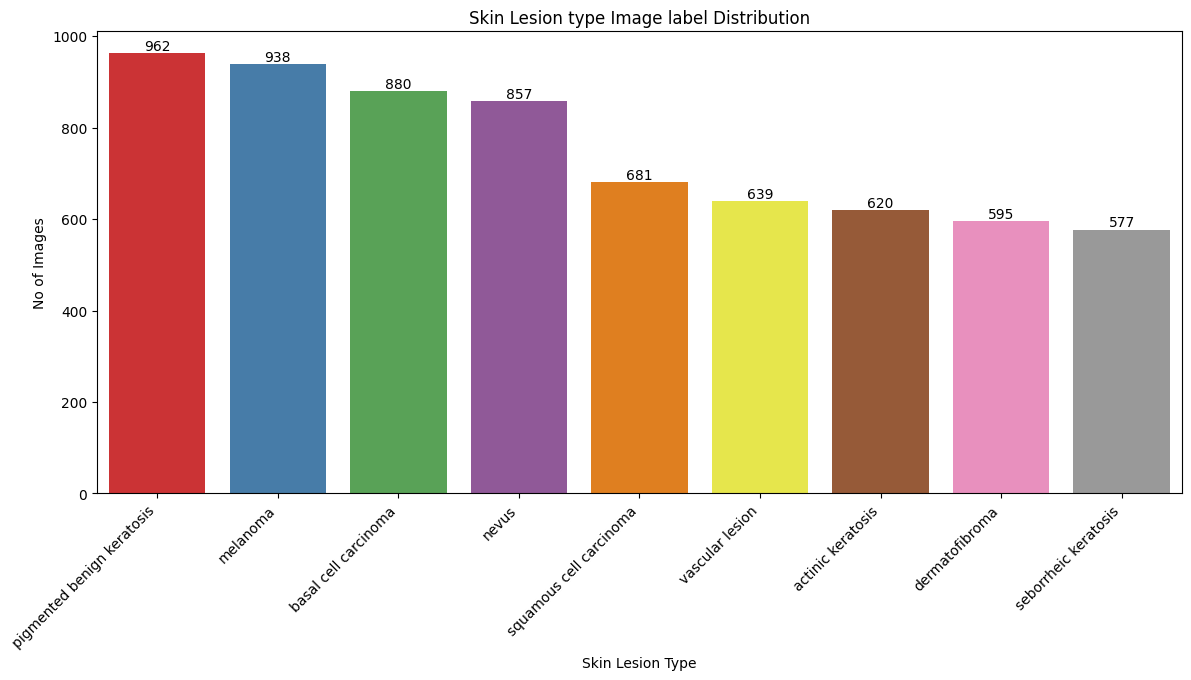

In [85]:
import seaborn as sns
plt.figure(figsize=(14, 6))
sns.barplot(augmented_df['Label'].value_counts() , palette = 'Set1');

# Show bar values on top of the bars
for bar in plt.gca().patches:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, int(height), ha='center', va='bottom')  # Adjust vertical offset (0.1) as needed

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.title('Skin Lesion type Image label Distribution')
plt.xlabel('Skin Lesion Type')
plt.ylabel('No of Images')
plt.show()

In [86]:
# Inspecting the classes (% age wise) after adding 500 samples per label

round(augmented_df['Label'].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,14.25
melanoma,13.90
basal cell carcinoma,13.04
nevus,12.70
squamous cell carcinoma,10.09
vascular lesion,9.47
actinic keratosis,9.19
dermatofibroma,8.82
seborrheic keratosis,8.55


The Inbalance across the classes are substantially reduced with the max now at 14% and min at 9% approximately

# 10. Train the model on the data created using Augmentor - Model 3

### a. Initializations

In [87]:
batch_size = 32
img_height = 180
img_width = 180

### b. Create a training dataset

In [88]:
# data_dir_train="path to directory with training data + data created using augmentor"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 5400 files for training.


### c. Create a validation dataset

In [89]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6749 files belonging to 9 classes.
Using 1349 files for validation.


### d. CNN neural network architecture design (included Batch normalization)

In [90]:
## your code goes here

model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

### e. Compile the model with adam optimizer

In [91]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### f. Summarize the model

In [92]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_5 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,990,249 (15.22 MB)

 Trainable params: 3,990,025 (15.22 MB)

 Non-trainable params: 224 (896.00 B)

### g. fit the model with epochs = 30

In [93]:
%%time
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 435s 3s/step - accuracy: 0.2772 - loss: 3.3128 - val_accuracy: 0.1038 - val_loss: 12.7590
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 422s 2s/step - accuracy: 0.3350 - loss: 1.8098 - val_accuracy: 0.2098 - val_loss: 6.3035
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - accuracy: 0.3784 - loss: 1.6283 - val_accuracy: 0.2913 - val_loss: 2.0533
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 435s 2s/step - accuracy: 0.3918 - loss: 1.5489 - val_accuracy: 0.3091 - val_loss: 1.8041
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.4393 - loss: 1.4370 - val_accuracy: 0.4159 - val_loss: 1.5458
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 453s 2s/step - accuracy: 0.4733 - loss: 1.3697 - val_accuracy: 0.3684 - val_loss: 1.9133
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 439s 2s/step - accuracy: 0.4791 - loss: 1.3363 - val_accuracy: 0.3514 - val_loss: 1.8134
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - accuracy: 0.4897 - loss: 1.2933 - val_acc

# h. Visualizing the training result

The Training accuracy is [0.2933333218097687, 0.34648147225379944, 0.36759260296821594, 0.3987036943435669, 0.44203704595565796, 0.46981480717658997, 0.4788888990879059, 0.48407408595085144, 0.49703702330589294, 0.503333330154419, 0.5144444704055786, 0.5274074077606201, 0.5379629731178284, 0.5451852083206177, 0.5616666674613953, 0.5842592716217041, 0.5842592716217041, 0.5992592573165894, 0.6135185360908508, 0.613703727722168, 0.6275925636291504, 0.6379629373550415, 0.6416666507720947, 0.6472222208976746, 0.6605555415153503, 0.6679629683494568, 0.6770370602607727, 0.6751852035522461, 0.6772222518920898, 0.696481466293335]
The Validation accuracy is [0.10378057509660721, 0.20978502929210663, 0.2913269102573395, 0.30911785364151, 0.41586360335350037, 0.3684210479259491, 0.3513713777065277, 0.39807265996932983, 0.3632320165634155, 0.4432913362979889, 0.4418087601661682, 0.4358784258365631, 0.48109710216522217, 0.48480355739593506, 0.5107486844062805, 0.5389177203178406, 0.318754643201828, 

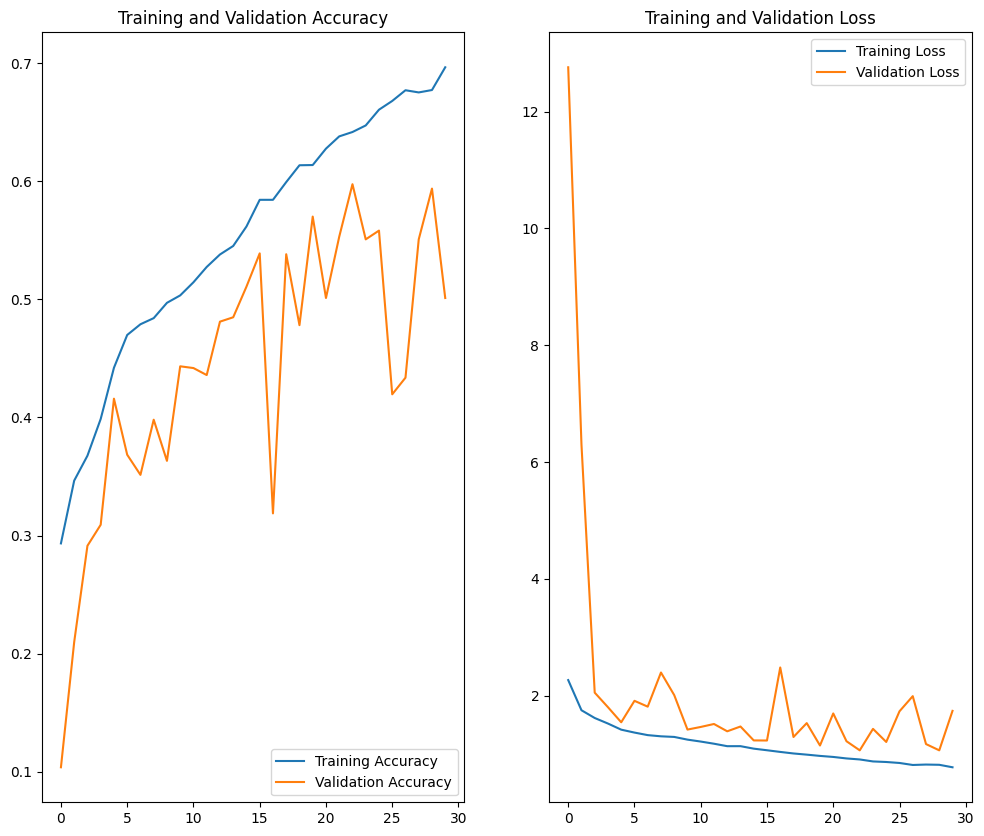

In [94]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print("The Training accuracy is " + str(acc))
print("The Validation accuracy is " + str(val_acc))

loss = history.history['loss']
val_loss = history.history['val_loss']
print("The Training loss is " + str(loss))
print("The Validation loss is " + str(val_loss))

epochs_range = range(epochs)

plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Actual Class: melanoma
Predicted Class: melanoma


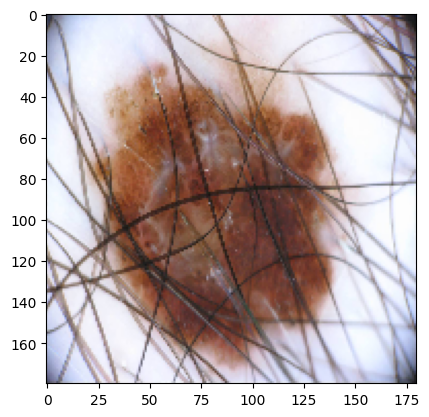

In [98]:
# Evaluating our model on one of the instances in the test set

from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[3], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[3] +'\n'+ "Predicted Class: " + predicted_class)

### Observations and further optimization scope

1. The Model 3 performance has increased substantially and can be optimized further by considering early stopping since epoch 29 has training accuracy of 68% and validation accuracy of 59%

2. The model can be further improved by increasing number of Epochs with Early stopping to 50 epochs , since it is very time consuming north of 6 hrs ( 4.5 hrs for 30 epochs ) , it rebooted multiple times when i tried

3. Increasing training data by adding 1000 images using the Augmenter class and training on it

4. Explore multiple Batch sizes 64 , 128 , 256 ...

5. Explore different positioning of Batch normalization

6. Build a deeper neural network with additional Convolutional layers

7. Build a wider neural network with bigger filters

8. Try different optimizer like RMSprop or SGD

9. Try different Dropout rate like 0.3 or 0.4